In [1]:
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset
import numpy as np
import json
from PIL import Image
import imageio


parts = [
    [0, 1], [1, 2], [2, 3], [3, 4],
    [0, 5], [5, 6], [6, 7], [7, 8],
    [0, 9], [9, 10], [10, 11], [11, 12],
    [0, 13], [13, 14], [14, 15], [15, 16],
    [0, 17], [17, 18], [18, 19], [19, 20]
]

groups6 = [[1, 2, 3], [5, 6, 7], [9, 10, 11], [13, 14, 15], [17, 18, 19], [0, 4, 8, 12, 16]]
groups1 = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]


class CMUHandDataset_LAM(Dataset):
    def __init__(self, data_root, mode='train', sigma=1, width=8, group='G20'):
        self.img_size = 368
        self.joints = 21  # 21 heat maps
        self.stride = 1
        self.label_size = self.img_size // self.stride  # 46
        self.sigma = sigma  # gaussian center heat map sigma
        self.width = width
        self.mode = mode

        if group == 'G6':
            self.group = groups6
            self.group_c = 6
        elif group == 'G1':
            self.group = groups1
            self.group_c = 1
        else:
            self.group = None
            self.group_c = 0

        self.data_root = data_root
        self.img_names = json.load(open(os.path.join(self.data_root, 'partitions.json')))[mode]
        self.all_labels = json.load(open(os.path.join(self.data_root, 'labels.json')))

        self.data_all = []
        self.load_all_data()

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        image, label_maps, lam_maps, img_name, w, h = self.data_all[idx]
        return image, label_maps, lam_maps, img_name, w, h

    def load_all_data(self):
        print('Load all data .....')

        for idx in range(len(self.img_names)):
            img_name = self.img_names[idx]  # '00000001.jpg'

            # ********************** get image **********************
            im = Image.open(os.path.join(self.data_root, 'imgs', img_name))
            w, h = im.size

            im = im.resize((self.img_size, self.img_size))
            image = transforms.ToTensor()(im)
#             image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                          std=[0.229, 0.224, 0.225])(image)

            # ******************** get label map **********************
            img_label = self.all_labels[img_name]  # origin label list  21 * 2

            label = np.asarray(img_label)  # 21 * 2
            label[:, 0] = label[:, 0] * self.img_size / self.stride / w
            label[:, 1] = label[:, 1] * self.img_size / self.stride / h

            label_maps = self.gen_label_heatmap(label)

            # ******************** get Limb map ********************
            lam_maps = self.generate_lam(label)
            if self.group:
                ori_maps = lam_maps
                lam_maps = self.limb_group(ori_maps, self.group_c, self.group)  # C,46,46

            lam_maps = torch.from_numpy(lam_maps).float()

            self.data_all.append([image, label_maps, lam_maps, img_name, w, h])
        print('Finish data loader .....\n')

    def gen_label_heatmap(self, label):
        label = torch.Tensor(label)

        grid = torch.zeros((self.label_size, self.label_size, 2))       # size:(46,46,2)
        grid[..., 0] = torch.Tensor(range(self.label_size)).unsqueeze(0)
        grid[..., 1] = torch.Tensor(range(self.label_size)).unsqueeze(1)
        grid = grid.unsqueeze(0)    # size:(1,46,46,2)
        labels = label.unsqueeze(-2).unsqueeze(-2)

        exponent = torch.sum((grid - labels)**2, dim=-1)    # size:(21,46,46)
        heatmaps = torch.exp(-exponent / 2.0 / self.sigma / self.sigma)
        return heatmaps

    def generate_lam(self, label):
        """
        generate 20 part affinity from 21 labels
        reference: https://github.com/NiteshBharadwaj/part-affinity/blob/master/src/data_process/coco_process_utils.py
        :param label:  list 21 * 2
        :param label_size: 46
        :return:
        """
        limb_maps = np.zeros((20, self.label_size, self.label_size))
        x, y = np.meshgrid(np.arange(self.label_size), np.arange(self.label_size))

        count = 0
        for part in parts:              # 20 parts
            x1, y1 = label[part[0]]        # vector start
            x2, y2 = label[part[1]]        # vector end

            length = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

            # unit vector
            v1 = (x2 - x1)/(length + 1e-8)  # in case the length is zero, so add 1e-8
            v2 = (y2 - y1)/(length + 1e-8)

            dist_along_part = v1 * (x - x1) + v2 * (y - y1)
            dist_per_part = np.abs(v2 * (x - x1) + (-v1) * (y - y1))

            mask1 = dist_along_part >= 0
            mask2 = dist_along_part <= length
            mask3 = dist_per_part <= self.width
            mask = mask1 & mask2 & mask3

            limb_maps[count, :, :] = mask.astype('float32')
            count += 1
        return limb_maps

    def limb_group(self, limb_maps, groupc, model_group):
        # ************ Grouping Limb Maps by Finger ************
        limb_group = np.zeros((groupc, self.label_size, self.label_size))
        for count, group in enumerate(model_group):
            for g in group:
                index = np.nonzero(limb_maps[g, ...])
                limb_group[count, ...][index] = 1
        return limb_group



class CMUHandDataset_LSH(Dataset):
    def __init__(self, data_root, mode='train', sigma=8, lsh_sigma=10, group='G20'):
        self.img_size = 368
        self.joints = 21  # 21 heat maps
        self.stride = 1
        self.label_size = self.img_size // self.stride  # 46
        self.sigma = sigma  # gaussian center heat map sigma
        self.lsh_sigma = lsh_sigma
        self.mode = mode
        if group == 'G6':
            self.group = groups6
            self.group_c = 6
        elif group == 'G1':
            self.group = groups1
            self.group_c = 1
        else:
            self.group = None
            self.group_c = 0

        self.data_root = data_root
        self.img_names = json.load(open(os.path.join(self.data_root, 'partitions.json')))[mode]
        self.all_labels = json.load(open(os.path.join(self.data_root, 'labels.json')))

        self.data_all = []
        self.load_all_data()

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        image, label_maps, lsh_maps, img_name, w, h = self.data_all[idx]
        return image, label_maps, lsh_maps, img_name, w, h

    def load_all_data(self):

        print('Load all data .....')
        for idx in range(len(self.img_names)):
            img_name = self.img_names[idx]  # '00000001.jpg'

            # ********************** get image **********************
            im = Image.open(os.path.join(self.data_root, 'imgs', img_name))
            w, h = im.size

            im = im.resize((self.img_size, self.img_size))
            image = transforms.ToTensor()(im)
#             image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                          std=[0.229, 0.224, 0.225])(image)

            # ******************** get label map **********************
            img_label = self.all_labels[img_name]  # list  21 * 2
            label = np.asarray(img_label)  # 21 * 2
            label[:, 0] = label[:, 0] * self.img_size / self.stride / w
            label[:, 1] = label[:, 1] * self.img_size / self.stride / h

            label_maps = self.gen_label_heatmap(label)

            # ******************** get Limb Segment map ********************
            lsh_maps = self.get_limb_segment_heatmap(label)
            if self.group:
                ori_maps = lsh_maps
                lsh_maps = self.limb_group(ori_maps, self.group_c, self.group)  # get group
                # if self.group_c > 1:
                #     g1_maps = self.limb_group(ori_maps, 1, groups1)  # size:(1,46,46)
                #     lsh_maps = np.concatenate([g1_maps, lsh_maps], axis=0)

            lsh_maps = torch.from_numpy(lsh_maps).float()
            self.data_all.append([image, label_maps, lsh_maps, img_name, w, h])
        print('Finish loading all data .....\n')

    def gen_label_heatmap(self, label):
        label = torch.Tensor(label)

        grid = torch.zeros((self.label_size, self.label_size, 2))       # size:(46,46,2)
        grid[..., 0] = torch.Tensor(range(self.label_size)).unsqueeze(0)
        grid[..., 1] = torch.Tensor(range(self.label_size)).unsqueeze(1)
        grid = grid.unsqueeze(0)
        labels = label.unsqueeze(-2).unsqueeze(-2)

        exponent = torch.sum((grid - labels)**2, dim=-1)    # size:(21,46,46)
        heatmaps = torch.exp(-exponent / 2.0 / self.sigma / self.sigma)
        return heatmaps

    def get_limb_segment_heatmap(self, label):
        """
        get ridge heat map base on the distance to a line segment
        Formula basis: https://www.cnblogs.com/flyinggod/p/9359534.html
        """
        limb_maps = np.zeros((20, self.label_size, self.label_size))
        x, y = np.meshgrid(np.arange(self.label_size), np.arange(self.label_size))
        count = 0
        for part in parts:              # 20 parts
            x1, y1 = label[part[0]]        # vector start
            x2, y2 = label[part[1]]        # vector end

            cross = (x2 - x1) * (x - x1) + (y2 - y1) * (y - y1)
            length2 = (x2 - x1) * (x2 - x1) + (y2 - y1) * (y2 - y1)
            r = (cross + 1e-8) / (length2 + 1e-8)
            px = x1 + (x2 - x1) * r
            py = y1 + (y2 - y1) * r

            mask1 = cross <= 0              # 46 * 46
            mask2 = cross >= length2
            mask3 = 1 - mask1 | mask2

            D2 = np.zeros((self.label_size, self.label_size))
            D2 += mask1.astype('float32') * ((x - x1) * (x - x1) + (y - y1) * (y - y1))
            D2 += mask2.astype('float32') * ((x - x2) * (x - x2) + (y - y2) * (y - y2))
            D2 += mask3.astype('float32') * ((x - px) * (x - px) + (py - y) * (py - y))

            limb_maps[count] = np.exp(-D2 / 2.0 / self.lsh_sigma / self.lsh_sigma)  # numpy 2d
            count += 1
        return limb_maps

    def limb_group(self, limb_maps, groupc, modelgroup):
        # ************ Grouping Limb Maps ************
        ridegemap_group = np.zeros((groupc, self.label_size, self.label_size))
        count = 0
        for group in modelgroup:    # group6 or group1
            for g in group:
                group_tmp = ridegemap_group[count, :, :]
                limb_tmp = limb_maps[g, :, :]
                max_id = group_tmp < limb_tmp    #
                group_tmp[max_id] = limb_tmp[max_id]
                ridegemap_group[count, :, :] = group_tmp
            count += 1
        return ridegemap_group

    
    
def heatmap_image(img, label):
    im_size = 368
    img = img.resize((im_size, im_size))

    x1 = 0
    x2 = im_size
    y1 = 0
    y2 = im_size
    
    target = Image.new('RGB', (im_size, im_size))

    heatmap = label   # heat map for single one joint
    # remove white margin
    plt.clf()
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    fig = plt.gcf()

    fig.set_size_inches(7.0 / 3, 7.0 / 3)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.imshow(heatmap)
    plt.savefig('tmp.jpg')

    heatmap = Image.open('tmp.jpg')
    heatmap = heatmap.resize((im_size, im_size))

    img_cmb = Image.blend(img, heatmap, 0.6)

    target.paste(img_cmb, (x1, y1, x2, y2))

    os.system('rm tmp.jpg')
    return target

data_root = '../data_sample/cmuhand'

LAM G1 ===========>
Load all data .....
Finish data loader .....



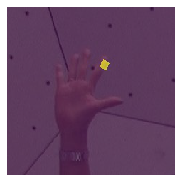

In [8]:
print('LAM G1 ===========>')
data = CMUHandDataset_LAM(data_root=data_root, mode='train', group='G20')
image, label_map, lam_map, img_name, w, h = data[0]
image = transforms.ToPILImage()(image)

# ***************** draw Limb map *****************
target = heatmap_image(image, lam_map[7, :, :])
plt.imshow(target)
target.save('ldm.jpg')

Load all data .....
Finish loading all data .....



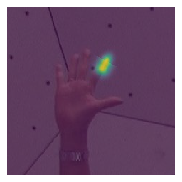

In [9]:
data = CMUHandDataset_LSH(data_root=data_root, mode='train', group='G20')
image, label_map, lsh_map, img_name, w, h = data[0]
image = transforms.ToPILImage()(image)

# ***************** draw Limb map *****************
target = heatmap_image(image, lsh_map[7, :, :])
plt.imshow(target)
target.save('lpm.jpg')

In [10]:
data_root = '../data_sample/cmuhand'
print('LAM G6 ===========>')
data = CMUHandDataset_LAM(data_root=data_root, mode='train', group='G6')
image, label_map, lsh_map, img_name, w, h = data[0]
image = transforms.ToPILImage()(image)


LAM G6 ===========>
Load all data .....
Finish data loader .....



LAM G1 ===========>
Load all data .....
Finish data loader .....



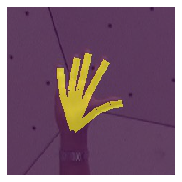

In [22]:
print('LAM G1 ===========>')
data = CMUHandDataset_LAM(data_root=data_root, mode='train', group='G1')
image, label_map, lam_map, img_name, w, h = data[0]
image = transforms.ToPILImage()(image)

# ***************** draw Limb map *****************
target = heatmap_image(image, lam_map[0, :, :])
plt.imshow(target)
target.save('../readme/ldm_g1.jpg')

LAM G6 ===========>
Load all data .....
Finish data loader .....

368


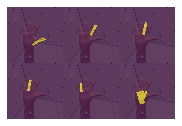

In [23]:
print('LAM G6 ===========>')
data = CMUHandDataset_LAM(data_root=data_root, mode='train', group='G6')
image, label_map, lam_map, img_name, w, h = data[0]
image = transforms.ToPILImage()(image)
imgs = []
for i in range(6):
    target = heatmap_image(image, lam_map[i, :, :])
    imgs.append(target)


im_size,_ = target.size
print(im_size)
new_image = Image.new('RGB', (im_size * 3, im_size * 2))
i = 0
k = 0
for im in imgs:
    new_image.paste(im, (i * im_size, 0 + im_size * k, i * im_size + im_size, im_size + im_size * k))
    i += 1
    if i == 3:
        i = 0
        k = 1
    
plt.imshow(new_image)
new_image.save('../readme/ldm_g6.jpg')

Load all data .....
Finish loading all data .....



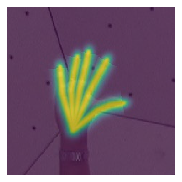

In [19]:
data = CMUHandDataset_LSH(data_root=data_root, mode='train', group='G1')
image, label_map, lsh_map, img_name, w, h = data[0]
image = transforms.ToPILImage()(image)

# ***************** draw Limb map *****************
target = heatmap_image(image, lsh_map[0, :, :])
plt.imshow(target)
target.save('../readme/lpm_g1.jpg')

LSH G6 ===========>
Load all data .....
Finish loading all data .....

368


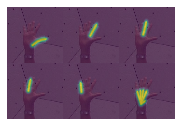

In [20]:
print('LSH G6 ===========>')
data = CMUHandDataset_LSH(data_root=data_root, mode='train', group='G6')
image, label_map, lsh_map, img_name, w, h = data[0]
image = transforms.ToPILImage()(image)
imgs = []
for i in range(6):
    target = heatmap_image(image, lsh_map[i, :, :])
    imgs.append(target)


im_size,_ = target.size
print(im_size)
new_image = Image.new('RGB', (im_size * 3, im_size * 2))
i = 0
k = 0
for im in imgs:
    new_image.paste(im, (i * im_size, 0 + im_size * k, i * im_size + im_size, im_size + im_size * k))
    i += 1
    if i == 3:
        i = 0
        k = 1
    
plt.imshow(new_image)
new_image.save('../readme/lpm_g6.jpg')